#### **Imports**

In [2]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
from qumcmc.energy_models import IsingEnergyFunction

from qumcmc.classical_mcmc_routines import classical_mcmc
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc     #for Qulacs Simulator backend
# from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics

#### **Define the Energy Model**

In [3]:
# define the model
np.random.seed(610358)# should always be in the same cell!  
n_spins = 10

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= shape_of_J )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.5 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')


            MODEL : my_model
Non-zero Interactions (J) :  90
Non-zero Bias (h) :  9
---------------------------------------------
Average Interaction Strength <|J|> :  0.5966799999999999
Average Bias Strength <|h|>:  0.5010000000000001
alpha :  0.5606804251097042
model beta :  1.0
---------------------------------------------


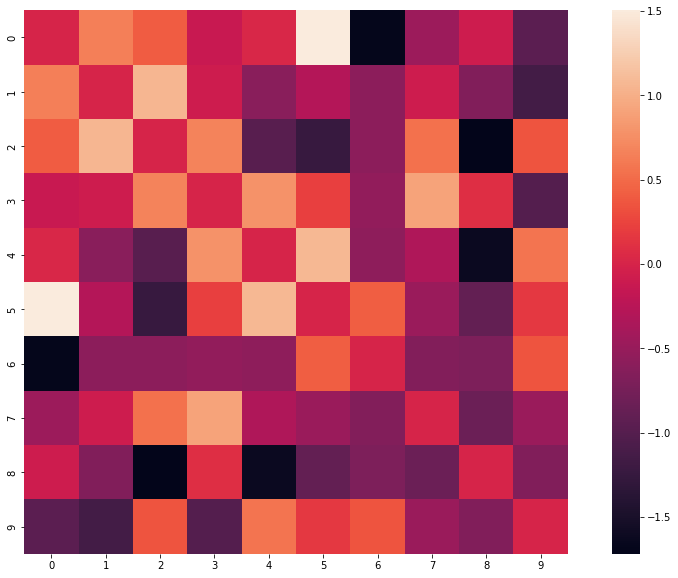

In [4]:
model.model_summary()

#### **Exact Analysis**

In [5]:
## set current beta
beta = 1.100209

## run exact sampling over all possible configurations 
model.run_exact_sampling(beta)

Running Exact Sampling | Model beta :  1.100209


running over all possible configurations: 100%|██████████| 1024/1024 [00:00<00:00, 40390.91it/s]

saving distribution to model ...


In [6]:
model.exact_sampling_status

True

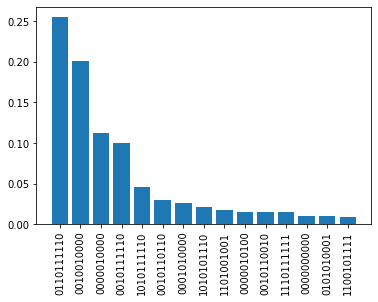

In [7]:
## get the distribution from model
bpd = model.boltzmann_pd

## plot the distribution
plot_bargraph_desc_order(bpd, label= 'Boltzmann Dist.', plot_first_few= 15)

#### **Run Classical MCMC**

In [8]:
steps = 10000
cl_chain =classical_mcmc(
    n_hops=steps,
    model=model,
    # return_last_n_states=10,
    temperature=1/beta,
)

starting with:  0101110110 with energy: 1.2780000000000005


running MCMC steps ...: 100%|██████████| 10000/10000 [00:00<00:00, 19899.91it/s]


In [9]:
cl_chain.states

[MCMCState(bitstring='0101110110', accepted=True),
 MCMCState(bitstring='1011011001', accepted=True),
 MCMCState(bitstring='1001111001', accepted=False),
 MCMCState(bitstring='1000000010', accepted=False),
 MCMCState(bitstring='0101110111', accepted=True),
 MCMCState(bitstring='0100010111', accepted=True),
 MCMCState(bitstring='0100111010', accepted=False),
 MCMCState(bitstring='0100011111', accepted=False),
 MCMCState(bitstring='0010100100', accepted=False),
 MCMCState(bitstring='1000000110', accepted=False),
 MCMCState(bitstring='0110000010', accepted=False),
 MCMCState(bitstring='1001110111', accepted=False),
 MCMCState(bitstring='0000011101', accepted=False),
 MCMCState(bitstring='1101011011', accepted=False),
 MCMCState(bitstring='0011111110', accepted=False),
 MCMCState(bitstring='0100000110', accepted=False),
 MCMCState(bitstring='0010001111', accepted=False),
 MCMCState(bitstring='1111100000', accepted=False),
 MCMCState(bitstring='1000111010', accepted=False),
 MCMCState(bitst

In [18]:
def get_trajectory_statistics(mcmc_chain: MCMCChain, model: IsingEnergyFunction):

    trajectory = mcmc_chain.states

    acceptance_prob = lambda si, sf: min(1, model.get_boltzmann_prob(sf.bitstring) / model.get_boltzmann_prob(si.bitstring) )
    hamming_diff = lambda si, sf: hamming_dist(si.bitstring, sf.bitstring)
    energy_diff = lambda si, sf: model.get_energy(sf.bitstring) - model.get_energy(si.bitstring)

    acceptance_statistic = [];hamming_statistic = [];energy_statistic = []
    
    current_state_index = 0; proposed_state_index = current_state_index + 1

    while proposed_state_index < len(trajectory) :

        
        print('trans: '+ str(trajectory[current_state_index].bitstring) + ' -> '+ str(trajectory[proposed_state_index].bitstring)+" status: "+str(trajectory[proposed_state_index].accepted)  )

        acceptance_statistic.append( acceptance_prob(trajectory[current_state_index], trajectory[proposed_state_index] ) )
        energy_statistic.append( energy_diff(trajectory[current_state_index], trajectory[proposed_state_index] ) )
        hamming_statistic.append( hamming_diff(trajectory[current_state_index], trajectory[proposed_state_index] ) )

        
        if trajectory[proposed_state_index].accepted :
            current_state_index =  proposed_state_index
        
        proposed_state_index += 1

    trajectory_statistics = {'energy':  np.array(energy_statistic), 'hamming':np.array(hamming_statistic), 'acceptance' :np.array(acceptance_statistic)}
    
    return trajectory_statistics

In [19]:
cl_statistic = get_trajectory_statistics(cl_chain, model)

trans: 0101110110 -> 1011011001 status: True
trans: 1011011001 -> 1001111001 status: False
trans: 1011011001 -> 1000000010 status: False
trans: 1011011001 -> 0101110111 status: True
trans: 0101110111 -> 0100010111 status: True
trans: 0100010111 -> 0100111010 status: False
trans: 0100010111 -> 0100011111 status: False
trans: 0100010111 -> 0010100100 status: False
trans: 0100010111 -> 1000000110 status: False
trans: 0100010111 -> 0110000010 status: False
trans: 0100010111 -> 1001110111 status: False
trans: 0100010111 -> 0000011101 status: False
trans: 0100010111 -> 1101011011 status: False
trans: 0100010111 -> 0011111110 status: False
trans: 0100010111 -> 0100000110 status: False
trans: 0100010111 -> 0010001111 status: False
trans: 0100010111 -> 1111100000 status: False
trans: 0100010111 -> 1000111010 status: False
trans: 0100010111 -> 0010110111 status: False
trans: 0100010111 -> 1111100000 status: False
trans: 0100010111 -> 0011111101 status: False
trans: 0100010111 -> 0111011000 statu

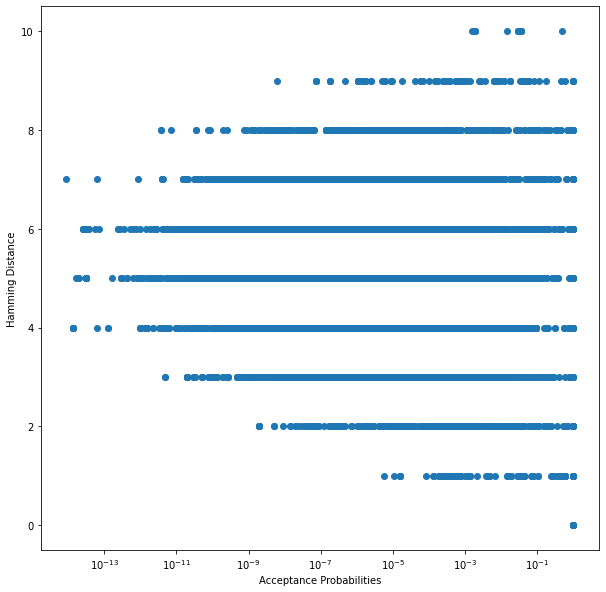

In [16]:
plt.figure(figsize=(10,10))
plt.scatter(cl_statistic['acceptance'], cl_statistic['hamming'])

plt.xscale("log")

plt.xlabel("Acceptance Probabilities")
plt.ylabel("Hamming Distance")
plt.show()

In [10]:

# fills, xticks, yticks = np.histogram2d(transition_probs_c, hamming_diff_c, bins=[model.num_spins,np.array(range(0,model.num_spins))], density= True)
# fills = fills / np.sum(fills)
# plt.figure(figsize=(10,10))
# sns.heatmap(np.round(fills.transpose(), decimals=3), square= True, xticklabels= np.round( xticks, decimals= 1) , yticklabels= np.round( yticks, decimals= 1), cmap="coolwarm", cbar= False, annot= True)


# plt.xlabel("Acceptance Probabilities")
# plt.ylabel("Hamming Distance")
# plt.title("Analytics of Proposed Moves : Uniform")
# plt.show()

#### **Run Quantum Enhaned MCMC**

In [22]:
steps = 10000
qamcmc_chain =quantum_enhanced_mcmc(
    n_hops=steps,
    model=model,
    temperature=1/beta,
)

starting with:  1010101011 with energy: -4.502000000000001
MCMCChain()


runnning quantum MCMC steps . ..: 100%|██████████| 10000/10000 [02:07<00:00, 78.68it/s]


In [23]:
qumcm_statistic = get_trajectory_statistics(qamcmc_chain, model)

trans: 1010101011 -> 0100100001 status: False
trans: 1010101011 -> 1101101110 status: True
trans: 1101101110 -> 0011111010 status: True
trans: 0011111010 -> 0101001101 status: False
trans: 0011111010 -> 1100001011 status: False
trans: 0011111010 -> 0111111111 status: True
trans: 0111111111 -> 0010111111 status: True
trans: 0010111111 -> 1000101010 status: False
trans: 0010111111 -> 1011001000 status: True
trans: 1011001000 -> 1010100000 status: False
trans: 1011001000 -> 0001011101 status: False
trans: 1011001000 -> 1010010001 status: False
trans: 1011001000 -> 0010000001 status: False
trans: 1011001000 -> 1000111110 status: False
trans: 1011001000 -> 1101001001 status: True
trans: 1101001001 -> 1001101001 status: False
trans: 1101001001 -> 1101000001 status: True
trans: 1101000001 -> 1010101000 status: False
trans: 1101000001 -> 1100101111 status: True
trans: 1100101111 -> 1100111111 status: False
trans: 1100101111 -> 1111101110 status: False
trans: 1100101111 -> 0100010101 status: Fa

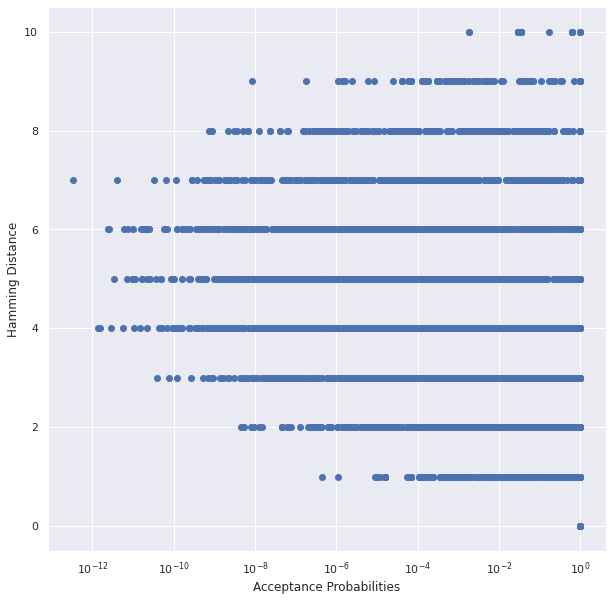

In [24]:
plt.figure(figsize=(10,10))
plt.scatter(qumcm_statistic['acceptance'], qumcm_statistic['hamming'])

plt.xscale("log")

plt.xlabel("Acceptance Probabilities")
plt.ylabel("Hamming Distance")
plt.show()

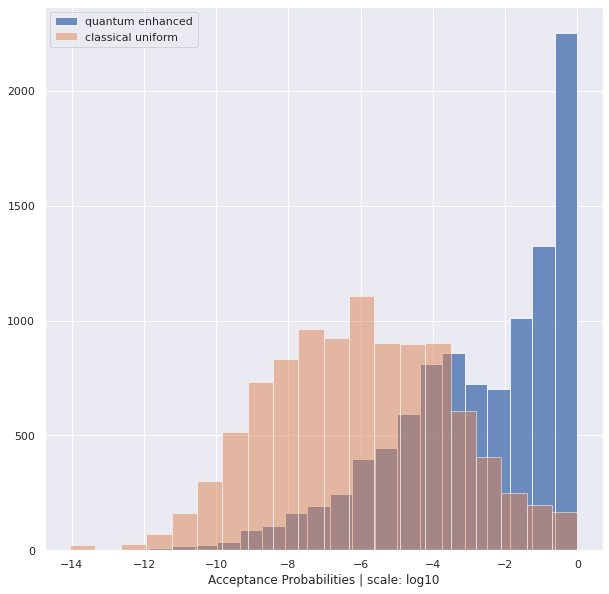

In [25]:
plt.figure(figsize=(10,10))

plt.hist(np.log10(qumcm_statistic['acceptance']),label= 'quantum enhanced' , alpha= 0.8, bins= 20)
plt.hist(np.log10(cl_statistic['acceptance']),label= 'classical uniform' ,alpha= 0.5, bins= 20)


# plt.xscale("log")

plt.xlabel("Acceptance Probabilities | scale: log10")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

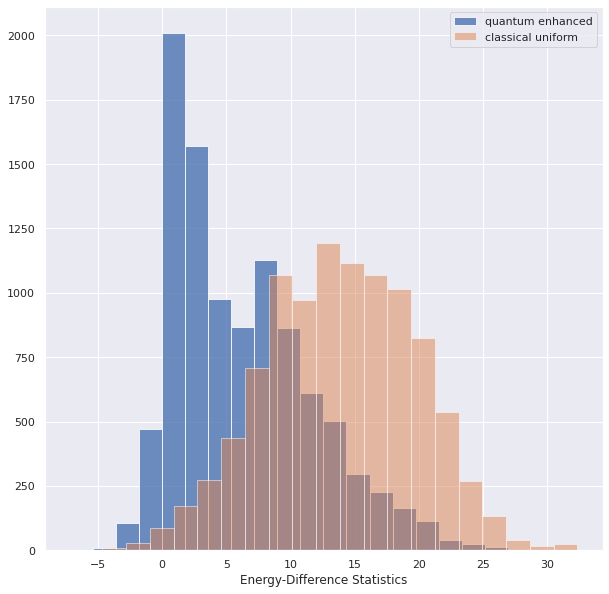

In [29]:
plt.figure(figsize=(10,10))

plt.hist(qumcm_statistic['energy'],label= 'quantum enhanced' , alpha= 0.8, bins= 20)
plt.hist(cl_statistic['energy'],label= 'classical uniform' ,alpha= 0.5, bins= 20)


# plt.xscale("log")

plt.xlabel("Energy-Difference Statistics")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

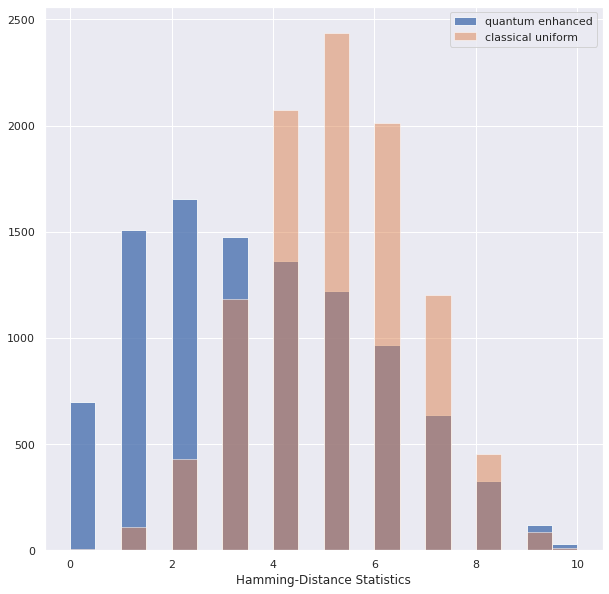

In [30]:
plt.figure(figsize=(10,10))

plt.hist(qumcm_statistic['hamming'],label= 'quantum enhanced' , alpha= 0.8, bins= 20)
plt.hist(cl_statistic['hamming'],label= 'classical uniform' ,alpha= 0.5, bins= 20)


# plt.xscale("log")

plt.xlabel("Hamming-Distance Statistics")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

In [31]:

# fills, xticks, yticks = np.histogram2d(transition_probs_q, hamming_diff_q, density= True)
# fills = fills / np.sum(fills)
# plt.figure(figsize=(10,10))
# sns.heatmap(np.round(fills.transpose(), decimals=3), square= True, xticklabels= np.round( xticks, decimals= 1) , yticklabels= np.round( yticks, decimals= 1), cmap="coolwarm", cbar= False, annot= True)
# plt.xlabel("Acceptance Probabilities")
# plt.ylabel("Hamming Distance")
# plt.title("Analytics of Proposed Moves : Quantum Enhanced ")
# plt.show()

#### **Convergence Analysis**

##### Magnetisation

In [46]:
magnetization_model = model.get_observable_expectation(magnetization_of_state)
magnetization_c = trajectory_c.running_avg_magnetization_as_list()
magnetization_q = trajectory_q.running_avg_magnetization_as_list()

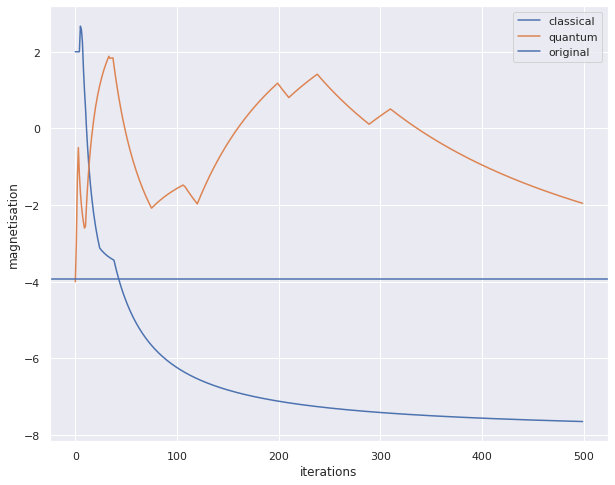

In [47]:
plt.figure(figsize=(10,8))
plt.plot(magnetization_c, label= 'classical')
plt.plot(magnetization_q, label= 'quantum')
plt.axhline(magnetization_model, label= 'original')
plt.xlabel("iterations")
plt.ylabel("magnetisation")
plt.legend()
plt.show()

##### JS Divergence

In [48]:
jsdiv_c = trajectory_c.running_js_divergence(model.boltzmann_pd)

  0%|          | 0/20 [00:00<?, ?it/s]/home/rajarsi/Documents/QBMS/qumcmc/qumcmc/prob_dist.py:112: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
/home/rajarsi/Documents/QBMS/qumcmc/qumcmc/prob_dist.py:112: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
/home/rajarsi/Documents/QBMS/qumcmc/qumcmc/prob_dist.py:112: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
/home/rajarsi/Documents/QBMS/qumcmc/qumcmc/prob_dist.py:112: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
100%|██████████| 20/20 [00:01<00:00, 11.96it/s]


In [49]:
jsdiv_q = trajectory_q.running_js_divergence(model.boltzmann_pd)

100%|██████████| 20/20 [00:00<00:00, 33.75it/s]


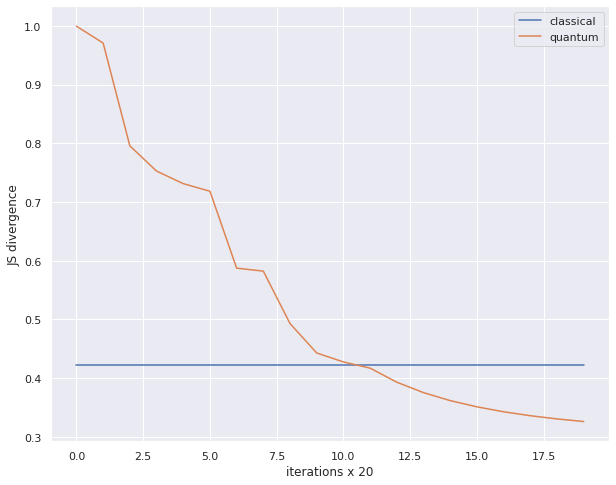

In [50]:
plt.figure(figsize=(10,8))
plt.plot(jsdiv_c, label= 'classical')
plt.plot(jsdiv_q, label= 'quantum')
plt.xlabel("iterations x 20")
plt.ylabel("JS divergence")
plt.legend()
plt.show()
